<div class="h1">The subtle art of winning March Madness</div>

This notebook tries to find some sense in (March) Madness. My approach is focused on the study of top teams and 'weak' a priori teams that become cinderellas. In this work I try to understand what makes teams perform well in the end-of season tournament and what makes 'underdogs' join that category. Note than I consider top performers those that made it to the Elite Eight round. In order to search for answers to this problem I have mainly focused on the data provided by the regular season. Since every year teams change a lot, I discarded data further from the same season where the tournament takes place because I assume it would add more noise than signal.

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
import lightgbm as lgb

import xgboost as xgb
from xgboost import XGBClassifier
import gc
import copy
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import plotly.express as px
from matplotlib.transforms import Affine2D
from sklearn.metrics.pairwise import cosine_similarity
#from adjustText import adjust_text

from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch

from advanced_stats import *
from elo_points import *
from matplotlib.pylab import rcParams
import warnings 
warnings.filterwarnings('ignore')

import seaborn as sns

In [135]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    margin:auto;
}
.prompt 
    display:none;
}  
</style>
""")

The sections where I divide my analysis are:
  - <a href='#distance'>The chance factor</a>
  - <a href='#cinde'>Do cinderellas get far?</a>
  - <a href='#comp'>What do competitive teams have in common?</a>
  - <a href='#ml'>Predictive Model</a>
  - <a href='#fail'>Where do predictive models fail?</a>

In [2]:
#Delete leaked games in training
def concat_row(r):
    if r['WTeamID'] < r['LTeamID']:
        res = str(r['Season'])+"_"+str(r['WTeamID'])+"_"+str(r['LTeamID'])
    else:
        res = str(r['Season'])+"_"+str(r['LTeamID'])+"_"+str(r['WTeamID'])
    return res

# Delete leaked from train
def delete_leaked_from_df_train(df_train, df_test):
    df_train['Concats'] = df_train.apply(concat_row, axis=1)
    df_train_duplicates = df_train[df_train['Concats'].isin(df_test['ID'].unique())]
    df_train_idx = df_train_duplicates.index.values
    df_train = df_train.drop(df_train_idx)
    df_train = df_train.drop('Concats', axis=1)
    
    return df_train 

def read_data(inFile, sep=','):
    df_op = pd.read_csv(filepath_or_buffer=inFile, low_memory=False, encoding='utf-8', sep=sep)
    return df_op


#ID calculator
def id_calculator(team_name_guess):
  identifier = MTeams[(MTeams.TeamName.str.startswith(team_name_guess))]['TeamID'].to_numpy()
  if len(identifier) != 1:
    print('Several teams with those characters')
    return int(identifier[0])
  else:
    return int(identifier)

#Team names claculator
def name_calculator(id):
  names_list_from_id = []
  for identifier in id:
    names = MTeams[MTeams.TeamID == identifier].TeamName.to_numpy()[0]
    names_list_from_id.append(names)

  return(names_list_from_id)

#Rivals calculator
def season_rivals(team_name,season):
  team_id = id_calculator(team_name)
  loser_rivals = MRegularSeasonCompactResults[(MRegularSeasonCompactResults.WTeamID==team_id)& (MRegularSeasonCompactResults.Season==season)]['LTeamName'].to_list()
  winner_rivals = MRegularSeasonCompactResults[(MRegularSeasonCompactResults.LTeamID==team_id)& (MRegularSeasonCompactResults.Season==season)]['WTeamName'].to_list()

  return loser_rivals, winner_rivals

def tournament_rivals(team_name,season):
    team_id = id_calculator(team_name)
    loser_rivals = tourney_result[(tourney_result.WTeamID==team_id)& (tourney_result.Season==season)]['LTeamID'].to_list()
    winner_rivals = tourney_result[(tourney_result.LTeamID==team_id)& (tourney_result.Season==season)]['WTeamID'].to_list()

    return loser_rivals, winner_rivals

#Elite Eight
def elite_eight(season_year,tourney_df):
  Wfinal_four_ids = tourney_df[((tourney_df.DayNum==145) | (tourney_df.DayNum==146)) & (tourney_df.Season==season_year)]['WTeamID'].to_list()
  Lfinal_four_ids = tourney_df[((tourney_df.DayNum==145) | (tourney_df.DayNum==146)) & (tourney_df.Season==season_year)]['LTeamID'].to_list()

  elite_eight_ids = Wfinal_four_ids + Lfinal_four_ids

  elite_eight_names = []

  for id in elite_eight_ids:
      elite_eight_name = MTeams[MTeams.TeamID == id]['TeamName'].to_numpy()[0]
      elite_eight_names.append(elite_eight_name)

  return elite_eight_names

#Final Four
#Days 145 and 146 Elite Eight games are played (winners teams play the Final Four). Day 152, Final Four games and Day 154 the final.
def final_four(season_year,tourney_df):
  final_four_ids = tourney_df[((tourney_df.DayNum==145) | (tourney_df.DayNum==146)) & (tourney_df.Season==season_year)]['WTeamID'].to_list()
  final_four_names = []
  for id in final_four_ids:
      final_four_name = MTeams[MTeams.TeamID == id]['TeamName'].to_numpy()[0]
      final_four_names.append(final_four_name)
  return final_four_names

# Upsets calculator
def upsets_calculator(season_year,tourney_df):
  upset_df = tourney_df[(tourney_df.Seed_diff >= 5) & (tourney_df.Season == season_year)]
  upset_df = upset_df[['WTeamID','LTeamID']]
  return upset_df

# Calculate teams which played in the tournament
def march_madness_teams(season_year,tourney_df):
    winner_teams = list(set(tourney_df[tourney_df.Season == season_year]['WTeamID'].to_list()))
    loser_teams = list(set(tourney_df[tourney_df.Season == season_year]['LTeamID'].to_list()))
    mm_teams = winner_teams + loser_teams
    return mm_teams

#Distance between 2 points on Earth
from math import radians, cos, sin, asin, sqrt 
def distance(lat1, lat2, lon1, lon2): 
      
    # The math module contains a function named 
    # radians which converts from degrees to radians. 
    lon1 = radians(lon1) 
    lon2 = radians(lon2) 
    lat1 = radians(lat1) 
    lat2 = radians(lat2) 
       
    # Haversine formula  
    dlon = lon2 - lon1  
    dlat = lat2 - lat1 
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
  
    c = 2 * asin(sqrt(a))  
     
    # Radius of earth in kilometers. Use 3956 for miles 
    r = 6371
       
    # calculate the result 
    return(c * r) 

In [14]:
#Data loading
tourney_result = pd.read_csv('../input/march-madness-analytics-2020/MDataFiles_Stage2/MNCAATourneyCompactResults.csv')
tourney_seed = pd.read_csv('../input/march-madness-analytics-2020/MDataFiles_Stage2/MNCAATourneySeeds.csv')
#submission_df = pd.read_csv(path_to_drive + '/input/google-cloud-ncaa-march-madness-2020-division-1-mens-tournament/MSampleSubmissionStage1_2020.csv')
MRegularSeasonCompactResults = pd.read_csv('../input/march-madness-analytics-2020/MDataFiles_Stage2/MRegularSeasonCompactResults.csv')
MTeams = pd.read_csv('../input/march-madness-analytics-2020/MDataFiles_Stage2/MTeams.csv')
MEvents_2018 = pd.read_csv('../input/march-madness-analytics-2020/2020DataFiles/2020DataFiles/2020-Mens-Data/MEvents2018.csv')
MEvents_2017 = pd.read_csv('../input/march-madness-analytics-2020/2020DataFiles/2020DataFiles/2020-Mens-Data/MEvents2017.csv')
MEvents_2016 = pd.read_csv('../input/march-madness-analytics-2020/2020DataFiles/2020DataFiles/2020-Mens-Data/MEvents2016.csv')

# game cities data
game_cities = pd.read_csv('../input/march-madness-analytics-2020/MDataFiles_Stage2/MGameCities.csv')
# city names
city_names = pd.read_csv('../input/march-madness-analytics-2020/MDataFiles_Stage2/Cities.csv')
location_data = pd.read_csv('/kaggle/input/location-data/location_data.csv')
# Adding Team Names to SeasonCompactResults
MRegularSeasonCompactResults = pd.merge(MRegularSeasonCompactResults,MTeams[['TeamID','TeamName']],left_on=['WTeamID'], right_on=['TeamID'], how='left')
MRegularSeasonCompactResults = pd.merge(MRegularSeasonCompactResults,MTeams[['TeamID','TeamName']],left_on=['LTeamID'], right_on=['TeamID'], how='left')

MRegularSeasonCompactResults = MRegularSeasonCompactResults.drop('TeamID_x', axis=1)
MRegularSeasonCompactResults = MRegularSeasonCompactResults.drop('TeamID_y', axis=1)
MRegularSeasonCompactResults.rename(columns={'TeamName_x':'WTeamName'}, inplace=True)
MRegularSeasonCompactResults.rename(columns={'TeamName_y':'LTeamName'}, inplace=True)

#season_enriched = create_advanced_stats()
season_enriched = pd.read_csv('../input/mncaa-enriched-season-data/MNCAASeasonDetailedResultsEnriched.csv')
elo_points = get_elo_points()

In [15]:
tourney_result[(tourney_result.Season==2017) & (tourney_result.LTeamID==1376)]
#id_calculator('South Car')
game_cities[(game_cities.Season==2017) & (game_cities.CRType=='NCAA') & (game_cities.WTeamID==1376)]
city_names[city_names.CityID==4139]

,CityID,City,State
138,4139,Greenville,SC


In [16]:
# SEASON DATA
# Number of wins in last 10 games calculation
Wins = season_enriched[['Season','WTeamID','DayNum']]
Wins.rename(columns={'WTeamID':'TeamID'}, inplace=True)
Wins['Result'] = 1
Loses = season_enriched[['Season','LTeamID','DayNum']]
Loses.rename(columns={'LTeamID':'TeamID'}, inplace=True)
Loses['Result'] = 0
season_results = pd.concat((Wins,Loses)).reset_index(drop=True)
season_results = season_results.sort_values(by=['Season', 'TeamID','DayNum'])
teams = season_results['TeamID'].unique()
years = season_results['Season'].unique()
last_10_df = pd.DataFrame(columns = season_results.columns)
for year in years:
  for team in teams:
  #for index, row in a.iterrows():
    last_10 = season_results[(season_results['Season']== year) & (season_results['TeamID']==team)][-10:]
    last_10_df = pd.concat((last_10_df,last_10))
last_10_df_sum = last_10_df.groupby(['Season', 'TeamID'])['Result'].sum().reset_index()
last_10_df_sum.rename(columns={'Result':'L10wins'}, inplace=True)

# Regular season aggregated data
style_metrics = ['Pos','AstR','Stl','Blk','FTAR','ORP','TOR','TSP']
performance_metrics = ['Score','eFGP','NetRtg','PIE']
other_metrics = ['FGA3','DR']
metrics = performance_metrics + style_metrics + other_metrics

winner_metrics = []
loser_metrics = []

for metric in metrics:
    winner_metrics.append('W' + metric)
    loser_metrics.append('L' + metric)
    
season_enrichedW = season_enriched[['Season','WTeamID'] + winner_metrics]
season_enrichedW.rename(columns={'WTeamID':'TeamID'}, inplace=True)

for variable in winner_metrics:
  
  season_enrichedW.rename(columns={variable:variable[1:]}, inplace=True)


season_enrichedL = season_enriched[['Season','LTeamID'] + loser_metrics]
season_enrichedL.rename(columns={'LTeamID':'TeamID'}, inplace=True)
for variable in loser_metrics:
    season_enrichedL.rename(columns={variable:variable[1:]}, inplace=True)

season_enriched_concat = pd.concat((season_enrichedW, season_enrichedL)).reset_index(drop=True)
season_enriched_concat = season_enriched_concat.groupby(['Season', 'TeamID'])[metrics].mean().reset_index()


# Merge season_enriched_concat with Elo table, Teams Names and last 10 games wins
season_enriched_concat = pd.merge(season_enriched_concat, elo_points, left_on=['Season', 'TeamID'], right_on=['season', 'team_id'], how='left')
#season_enriched_concat = season_enriched_concat.drop('Season', axis=1)
season_enriched_concat = season_enriched_concat.drop('season', axis=1)
season_enriched_concat = season_enriched_concat.drop('team_id', axis=1)
#Merge with last_10
season_enriched_concat = pd.merge(season_enriched_concat,last_10_df_sum,left_on=['Season','TeamID'], right_on=['Season','TeamID'], how='left')
#Merge with Names
season_enriched_concat = pd.merge(season_enriched_concat,MTeams[['TeamID','TeamName']],left_on=['TeamID'], right_on=['TeamID'], how='left')

In [17]:
# TOURNAMENT DATA
# Adding Seed
tourney_result = pd.merge(tourney_result, tourney_seed, left_on=['Season', 'WTeamID'], right_on=['Season', 'TeamID'], how='left')
tourney_result.rename(columns={'Seed':'WSeed'}, inplace=True)
tourney_result = tourney_result.drop('TeamID', axis=1)
tourney_result = pd.merge(tourney_result, tourney_seed, left_on=['Season', 'LTeamID'], right_on=['Season', 'TeamID'], how='left')
tourney_result.rename(columns={'Seed':'LSeed'}, inplace=True)
tourney_result = tourney_result.drop('TeamID', axis=1)

def get_seed(x):
    return int(x[1:3])

tourney_result['WSeed'] = tourney_result['WSeed'].map(lambda x: get_seed(x))
tourney_result['LSeed'] = tourney_result['LSeed'].map(lambda x: get_seed(x))
tourney_result['Seed_diff'] = tourney_result['WSeed'] - tourney_result['LSeed']
Wins_tourney = tourney_result[['Season','WTeamID','DayNum']]
Wins_tourney.rename(columns={'WTeamID':'TeamID'}, inplace=True)
Wins_tourney['Result'] = 1
Loses_tourney = tourney_result[['Season','LTeamID','DayNum']]
Loses_tourney.rename(columns={'LTeamID':'TeamID'}, inplace=True)
Loses_tourney['Result'] = 0
tourney_results_concat = pd.concat((Wins_tourney,Loses_tourney)).reset_index(drop=True)
tourney_results_concat = tourney_results_concat[tourney_results_concat.Season>=2003]

<a id='distance'></a>
<div class="h3">The chance factor</div>

Before beginning evaluation teams, there is a variable which teams have nothing to do about, that is the location of the tournament games. Locations are chosen randomly across the United States, so I wonder how much that random process affect the development of the tournament. To check this I have studied the distance from the city where the university is located and the place where the game is played on.

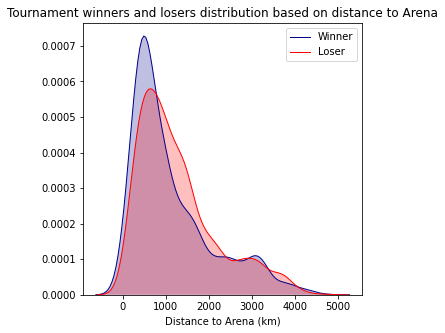

In [128]:
location_ncaa_games = pd.merge(game_cities,city_names,left_on=['CityID'],right_on=['CityID'],how='left')
location_ncaa_games = location_ncaa_games[location_ncaa_games.CRType=='NCAA']
location_ncaa_games_extended = pd.merge(location_ncaa_games,location_data[['CityID','lat','lng']],left_on=['CityID'],right_on=['CityID'],how='left').drop(['City',
'State'],axis = 1)
location_ncaa_games_extended.rename(columns={'lat':'game_lat'}, inplace=True)
location_ncaa_games_extended.rename(columns={'lng':'game_lng'}, inplace=True)
location_ncaa_games_winner = pd.merge(location_ncaa_games_extended,location_data[['TeamID','lat','lng']],left_on=['WTeamID'],right_on=['TeamID'],how='left').drop(['TeamID'],axis=1)
location_ncaa_games_winner.rename(columns={'lat':'W_lat'}, inplace=True)
location_ncaa_games_winner.rename(columns={'lng':'W_lng'}, inplace=True)
location_ncaa_games_winner_loser = pd.merge(location_ncaa_games_winner,location_data[['TeamID','lat','lng']],left_on=['LTeamID'],right_on=['TeamID'],how='left').drop(['TeamID'],axis=1)
location_ncaa_games_winner_loser.rename(columns={'lat':'L_lat'}, inplace=True)
location_ncaa_games_winner_loser.rename(columns={'lng':'L_lng'}, inplace=True)
loc_df = location_ncaa_games_winner_loser
loc_df['W_dist'] = np.vectorize(distance)(loc_df['game_lat'], loc_df['W_lat'], loc_df['game_lng'], loc_df['W_lng'])
loc_df['L_dist'] = np.vectorize(distance)(loc_df['game_lat'], loc_df['L_lat'], loc_df['game_lng'], loc_df['L_lng'])
loc_df = loc_df.drop(['W_lat','W_lng','L_lat','L_lng','CRType','game_lat','game_lng'],axis=1)
loc_df['Dist_diff'] = loc_df['L_dist']-loc_df['W_dist']
#loc_df = loc_df.drop(['L_dist','W_dist'],axis=1)
sns.distplot(loc_df['W_dist'], hist=False, kde=True, 
             bins=int(180/5), color = 'darkblue',
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 1, "shade": True},
            label= 'Winner')
sns.distplot(loc_df['L_dist'], hist=False, kde=True, 
             bins=int(180/5), color = 'red',
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 1, "shade": True},
            label= 'Loser')
plt.legend(title='Distance to arena', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);
plt.title('Tournament winners and losers distribution based on distance to Arena')
plt.ylabel('')
plt.xlabel('Distance to Arena (km)')
plt.legend();

The mathcup output distribution for the loser teams seem to be moved towards higher travelled distances. Although it may not be significant, there is evidence that travelling distance somehow affects outcome of the game.

<a id='cinde'></a>
<div class="h3">Do cinderellas get far?</div>

A question that arises when an underdog becomes a _cinderella_ is if it has just been a matter of luck or actually it is an underrated competitive team with high chances of making into the final rounds. To help clarify this doubt we can have a look at how many 'cinderellas' (teams that have beaten a team with 5 points less seeding) have made it to the Elite Eight or Final Four rounds.

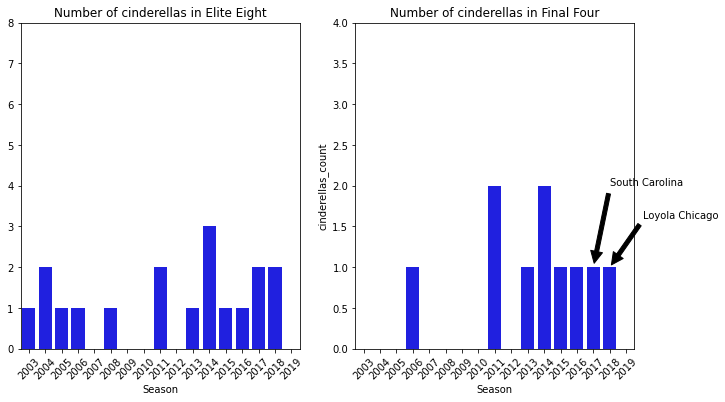

In [170]:
year_list = list(range(2003, 2020))
#d = np.empty((2, 0)).tolist()
dicts = {'year','count'}
list_of_tuples_four = []
list_of_tuples_eight = []
pd.DataFrame(columns = ['Season','count'])
for year in year_list:
  upsets = upsets_calculator(year,tourney_result)
  cinderellas = upsets.WTeamID.to_list()
  conderellas_list = name_calculator(cinderellas)
  final_four_list = final_four(year,tourney_result)
  elite_eight_list = elite_eight(year,tourney_result)
  count_four = len(set(conderellas_list) & set(final_four_list))
  count_eight = len(set(conderellas_list) & set(elite_eight_list))
  pair_four = (year,count_four)
  pair_eight = (year,count_eight)
  list_of_tuples_four.append(pair_four)
  list_of_tuples_eight.append(pair_eight)
  #dicts[year] = count

cinderellas_df_four = pd.DataFrame(data=list_of_tuples_four,columns = ['Season','cinderellas_count'])
cinderellas_df_eight = pd.DataFrame(data=list_of_tuples_eight,columns = ['Season','cinderellas_count'])
#set(names_lista).intersection(set(names_list))


fig, ax = plt.subplots(1,2,figsize=(11,6))
plot_eight = sns.barplot(x="Season", y="cinderellas_count", data=cinderellas_df_eight,ax=ax[0], color= 'blue')
plot_four = sns.barplot(x="Season", y="cinderellas_count", data=cinderellas_df_four,ax=ax[1], color= 'blue')
axes = plot_four.axes
ax[0].set_ylim(0,8)
ax[1].set_ylim(0,4)
ax[0].set_title('Number of cinderellas in Elite Eight')
ax[1].set_title('Number of cinderellas in Final Four')
plot_four.set_xticklabels(plot_four.get_xticklabels(), rotation=45)
ax[0].set_ylabel('')
ax[1].set_xlabel
plot_eight.set_xticklabels(plot_eight.get_xticklabels(), rotation=45)
ax[1].annotate('South Carolina', xy=(14, 1), xytext=(15, 2),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )
ax[1].annotate('Loyola Chicago', xy=(15, 1), xytext=(17, 1.6),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )
plt.show()

There has been 16 _cinderellas_ in the Elite Eight rounds in the past 17 years and 10 _cinderellas_ in the Final Four rounds. So, on average there has almost been one _cinderella_ in Elite Eight round every year since 2003. That makes me ask: "Are _cinderellas_ really _cinderellas_, or are those teams just underrated?"

This drives me to the next study, that tries to understand which are the shared characteristics of Elite Eight teams throughout the different years.

<a id='comp'></a>
<div class="h3">What do competitive teams have in common?</div>

To answer this question I have aggreagated the regular season data for each year and team by averaging the statistics for every game played during the regular season. Furthermore, I have included elo ratings (https://www.kaggle.com/lpkirwin/fivethirtyeight-elo-ratings) and advanced statistics (https://www.kaggle.com/lnatml/feature-engineering-with-advanced-stats) to make a more complete analysis.

Firstly, I want to know how does the last 10 games of the regular season record affect the performance of the teams during March Madness. One may think this could have a big impact in one team success in the final tournament.

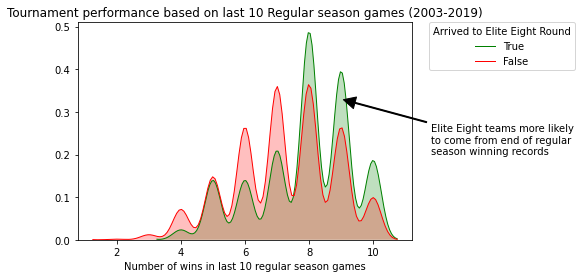

In [20]:
# Last 10 wins before tournament
sum_tourney_wins = (tourney_results_concat.groupby(['Season', 'TeamID'])['Result']
                     .sum()
                     .rename('tourney_wins')
                     .reset_index())
sum_tourney_wins = pd.merge(sum_tourney_wins,last_10_df_sum,left_on=['Season','TeamID'], right_on=['Season','TeamID'], how='left')
counts_foundation = (sum_tourney_wins.groupby(['L10wins'])['tourney_wins']
                     .value_counts(normalize=True)
                     .mul(100)
                     .rename('pct of wins')
                     .reset_index()
                     .sort_values('L10wins'))

sum_tourney_wins_divided = sum_tourney_wins.copy()
def made_final_four (row):
    if row['tourney_wins'] >= 5:
      return True
    else:
        return False
sum_tourney_wins_divided['final_four'] = sum_tourney_wins_divided.apply (lambda row: made_final_four(row), axis=1)

def made_elite_eight (row):
    if row['tourney_wins'] >= 4:
      return True
    else:
        return False
sum_tourney_wins_divided['elite_eight'] = sum_tourney_wins_divided.apply (lambda row: made_elite_eight(row), axis=1)

# Plotting distribution differences Final four vs not final four based on last 10 reg season wins
color_palette = ['green','red']
i=0
for elite_eight_bool in [True,False]:
    subset = sum_tourney_wins_divided[sum_tourney_wins_divided['elite_eight'] == elite_eight_bool]
    sns.distplot(subset['L10wins'], hist=False, kde=True, color = color_palette[i], 
             #bins=int(180/5),
             #hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 1, "shade": True, "bw":0.25},
            label= str(elite_eight_bool))
    i+=1
# Put the legend out of the figure
plt.title('Tournament performance based on last 10 Regular season games (2003-2019)')
plt.ylabel('')
plt.xlabel('Number of wins in last 10 regular season games')
plt.annotate('Elite Eight teams more likely\nto come from end of regular\nseason winning records', xy=(9, 0.33), xytext=(11.8, 0.2),
            arrowprops=dict(facecolor='black', shrink=0.025,width=1),
            )

plt.legend(title='Arrived to Elite Eight Round', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

From the above figure we can observe that those teams which get to the quarter finals tend to come from high winning records in the last 10 games.

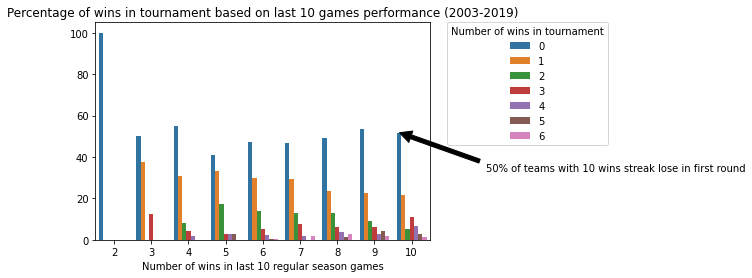

In [21]:
# Last 10 wins before tournament
sum_tourney_wins = (tourney_results_concat.groupby(['Season', 'TeamID'])['Result']
                     .sum()
                     .rename('tourney_wins')
                     .reset_index())
sum_tourney_wins = pd.merge(sum_tourney_wins,last_10_df_sum,left_on=['Season','TeamID'], right_on=['Season','TeamID'], how='left')
counts_foundation = (sum_tourney_wins.groupby(['L10wins'])['tourney_wins']
                     .value_counts(normalize=True)
                     .mul(100)
                     .rename('pct of wins')
                     .reset_index()
                     .sort_values('L10wins'))
sns.barplot(x="L10wins", y="pct of wins", hue="tourney_wins", data=counts_foundation)
# Put the legend out of the figure
plt.title('Percentage of wins in tournament based on last 10 games performance (2003-2019)')
plt.ylabel('')
plt.xlabel('Number of wins in last 10 regular season games')
plt.annotate('50% of teams with 10 wins streak lose in first round', xy=(7.55, 52.5), xytext=(10, 33),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )
plt.legend(title='Number of wins in tournament', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

However, the average number of wins in the last 10 regular season games is 7.32 for teams entering March Madness. This suggests that teams making it to the NCCA final tournament are teams that have a good record at the end of the season. Below we can observe the distribution differences between teams coming from 7 (average March Madness team) wins out of last 10 vs teams with 10 wins streak. Now we can see that the difference is not significant, in fact approximately the same number of teams fail to even win one game. This explains why it would not be a good variable to predict matchups.

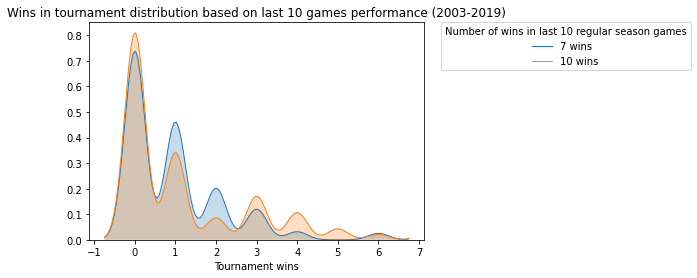

In [22]:
# Last 10 games, 7 wins vs 10 wins (small difference!!), average NCAA teams has 7
for last_number_wins in [7,10]:
    subset = sum_tourney_wins[sum_tourney_wins['L10wins'] == last_number_wins]
    sns.distplot(subset['tourney_wins'], hist=False, kde=True, 
             #bins=int(180/5), #color = 'darkblue',
             #hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 1, "shade": True, "bw":0.25},
            label= str(last_number_wins) + ' wins')
# Put the legend out of the figure
plt.title('Wins in tournament distribution based on last 10 games performance (2003-2019)')
plt.ylabel('')
plt.xlabel('Tournament wins')

plt.legend(title='Number of wins in last 10 regular season games', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

<div class="h3">A strong predictor</div>

Elo rating is a mathod for calculating the relative skill levels of players in zero-sum games such as chess. This feature brings information about the current state of a single team. Every team in the competition starts with an Elo rating of 1500 points and, each game of every season its value gets updated based on game scores and home advantage factor as follows:
   

<script src="//yihui.org/js/math-code.js"></script>
<!-- Just one possible MathJax CDN below. You may use others. -->
<script async
  src="//mathjax.rstudio.com/latest/MathJax.js?config=TeX-MML-AM_CHTML">
</script>

$$Elo\_rating_{t} = Elo\_rating_{t-1} + K * \frac{margin+3}{7.5 + 0.06 * (elo_{winner}-elo_{loser})}*(1-\frac{1}{10-\frac{(-elo_{winner}-elo_{loser})}{400}+1})$$

Where margin represents the game score difference, $elo_{winner}$ and $elo_{loser}$ the elo points before the game adjusted for home advantage (home team receives 100 Elo points, while the visitor gets substracted 100) and k the update factor, in charge of adjusting the speed at which Elo ratings are updated from game to game (K = 20 for NBA).

Here we can see Virginia vs Duke Elo points since 1985:

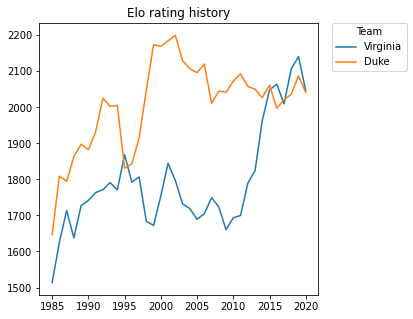

In [136]:
virginia_elo = elo_points[elo_points.team_id==1438]#id_calculator('Virginia')
duke_elo = elo_points[elo_points.team_id==id_calculator('Duke')]

plt.plot(virginia_elo.season,virginia_elo.season_elo,label= 'Virginia')
plt.plot(duke_elo.season,duke_elo.season_elo,label= 'Duke')
plt.title("Elo rating history")
plt.legend(title='Team', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

To better understand how Elo ratings can correlate to a good performance in March Madness I plot the distributions of Elo rating for Elite Eight teams and the rest of the teams:

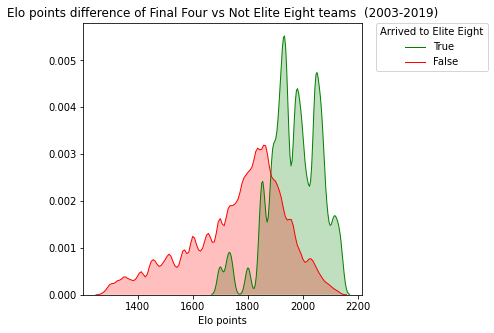

In [23]:
#Elo points with tourney results (Final_four boolean) merge
tourney_elo = pd.merge(sum_tourney_wins_divided,elo_points,left_on=['Season','TeamID'],right_on=['season', 'team_id'],how='left')
tourney_elo = tourney_elo.drop(['tourney_wins','L10wins','team_id','season'],axis=1)

#Plotting distribution difference between Elo points
rcParams['figure.figsize'] = 5,5

color_palette = ['green','red']
##### Elite Eight
i=0
for elite_eight_bool in [True,False]:
    subset = tourney_elo[tourney_elo['elite_eight'] == elite_eight_bool]
    sns.distplot(subset['season_elo'], hist=False, kde=True, color = color_palette[i], 
             #bins=int(180/5),
             #hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 1, "shade": True, "bw":10},
            label= str(elite_eight_bool))
    i+=1
# Put the legend out of the figure
plt.title('Elo points difference of Final Four vs Not Elite Eight teams  (2003-2019)')
plt.ylabel('')
plt.xlabel('Elo points')
#plt.annotate('Final Four teams more likely\nto come from regular season\nwinning streaks', xy=(9, 0.4), xytext=(11.8, 0.2),
#            arrowprops=dict(facecolor='black', shrink=0.025,width=1),
#            )
plt.legend(title='Arrived to Elite Eight', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);


plt.show()

This graph suggests that could be a strong indicator of the outcome of a matchup since there is a clear difference in the distributions.

In [33]:
def pca_season(df,season_year,features,n_components):
    #df = df[df['Season']==season_year].reset_index()
    # Separating out the features
    x = df.loc[:, features].values
    # Separating out the target
    #y = df.loc[:,['target']].values
    # Standardizing the features
    x = StandardScaler().fit_transform(x)

    pca = PCA(n_components=n_components)
    pca.fit(x)
    principalComponents = pca.transform(x)
    if n_components == 2:
        principalComponentsvalues = pd.DataFrame(data = principalComponents
                    , columns = ['principal component 1', 'principal component 2'])
    elif n_components == 3:
        principalComponentsvalues = pd.DataFrame(data = principalComponents
                    , columns = ['principal component 1', 'principal component 2', 'principal component 3'])
    return pca, principalComponentsvalues

Next, I show a dimensionality reduction method applied to the aggregated data for every team and season. Principal Complonent Analysis projects the original cloud of data into othogonal axis by maintining as much information as possible. In this case, I take the aggregated data with several factors and apply PCA and showing the first two principal components, which retain more than 70\% of the inital information. This allows us to observe which are the differences between teams in terms of regular season performance. If the factors used are able to determine cimilarities between team we will expect similar teams to lay closely in the 2D representation.

<script src="//yihui.org/js/math-code.js"></script>
<!-- Just one possible MathJax CDN below. You may use others. -->
<script async
  src="//mathjax.rstudio.com/latest/MathJax.js?config=TeX-MML-AM_CHTML">
</script>

Some of the used variables are:

- NetRtg: shows a balanced indicator of a team offensive and defensive capabilities. It is calculated as the difference between scored and allowed points per 100 possesions:

$$NetRtg = OffRtg - DeffRtg = 100 \cdot \frac{Points Made}{Poss} - 100 \cdot \frac{Points Allowed}{Poss}$$

- FTAR: the team's ability of drawing faults, proportion of shots made in the free line:

$$FTAR = \frac{FTA}{FGA}$$

- eFG: effective Field Goal takes into account that 3-pointers are worth 1.5 more than 2-pointers,

$$eFG = FGM + \frac{0.5 \cdot 3PM}{FGA}$$

- PIE: Team (or Player) Impact Estimate groups several indicators into a single metric that represent how 'impactful' has the team been:
    
    $$PIE = PTS + FGM + FTM - FGA - FTA + DR + 0.5*OR + AST + STL + 0.5*BLK - PF - TOV$$
    
Also end of the season Elo points and the number of wins during thelast 10 regular season games. Note that since this a regular season metrics 'summary' I haven't included the experts pre-tournament seeding.

In [40]:
def PCA_matchup(teams_list, df,features,season_year,every_team,draw_ellipse=(0,0)):
    #names_list can be either names or ids
    df = df[df['Season']==season_year].reset_index()
    
    #To do PCA of only teams in tournament
    if every_team == False:
        df = df[df['March_mad_team']==0].reset_index()
    labels_march = df['March_mad_team'].to_numpy()
    #df = df.drop(['March_mad_team'],axis=1).reset_index()

    pca, principalComponents_df = pca_season(df,season_year,features,2)
    

    team_id_list = []
    team_name_list = []
    if isinstance(teams_list[0], str):
        for name in teams_list:
            team_id = MTeams[(MTeams.TeamName.str.startswith(name))]['TeamID'].to_numpy()[0]
            team_id_list.append(team_id)
            team_name = MTeams[(MTeams.TeamName.str.startswith(name))]['TeamName'].to_numpy()[0]
            team_name_list.append(team_name)
    else:
        team_id_list = teams_list.copy()
        team_name_list = name_calculator(team_id_list)
    # Index in dataframe
    reset_indeces = []
    for id in team_id_list:
        index = df.index[df['TeamID']==id][0]
        reset_indeces.append(index)

    # Data values from PCA (projection on axes)
    pca_data_projections = []
    for index in reset_indeces:
        projection = principalComponents_df.iloc[index]
        pca_data_projections.append(projection)

    kmeans = KMeans(n_clusters=5, random_state=0)
    kmeans.fit(principalComponents_df.values)
    centroids = kmeans.cluster_centers_
    labels_kmeans = kmeans.labels_

    fig = plt.figure(figsize = (5,5))
    ax = fig.add_subplot(1,1,1)
    
    from matplotlib.patches import Ellipse
    if draw_ellipse == (0,0):
        pass
    else:
        e = Ellipse(xy=draw_ellipse, width=1, height=1,facecolor='none',edgecolor='red')
        ax.add_artist(e)
    
    ax.scatter(centroids[:, 0], centroids[:, 1],
            marker='', s=169, linewidths=3,
            color='r', zorder=10)
    

    #cmap, norm = mpl.colors.from_levels_and_colors([0, 1], ['blue', 'black'])
    ax.set_xlabel('PC 1 ' + str(round(pca.explained_variance_ratio_[0]*100,2)) + '%', fontsize = 15)
    ax.set_ylabel('PC 2 '+ str(round(pca.explained_variance_ratio_[1]*100,2)) + '%', fontsize = 15)
    ax.set_title(str(season_year) + ' Season PCA', fontsize = 20)
    ax.scatter(principalComponents_df.loc[:,'principal component 1'],
            principalComponents_df.loc[:,'principal component 2'],
             c=labels_march.astype(np.float), cmap='coolwarm'#, norm=norm
             )
    coeff = pca.components_
    n = coeff.shape[1]
    texts = []
    #for i in range(n):
        #plt.arrow(0, 0, coeff[0,i]*3, coeff[1,i]*3,color = 'r',alpha = 0.5)
        #plt.text(coeff[0,i]* 3.15, coeff[1,i] * 3.15, features[i], color = 'r', ha = 'center', va = 'center',fontsize = 13)
        #adjust_text(texts, only_move='y', arrowprops=dict(arrowstyle="->", color='r', lw=0.5))
    #if isinstance(names_list[0], str):
    for i, data_point in enumerate(pca_data_projections):
        ax.annotate(team_name_list[i],data_point,
                    xytext = data_point + 0.5,
                    arrowprops=dict(arrowstyle="->",
                                    connectionstyle="arc3"))
    return ax, coeff, principalComponents_df
  #ax.grid()

In [154]:
#Chossing features in PCA
style_metrics = ['Pos','AstR','Stl','ORP','TOR','TSP']
#style_metrics = ['Pos','TOR','AstR','TSP']
performance_metrics = ['NetRtg','L10wins','FTAR','PIE','eFGP']
random_metrics = ['TOR','Stl'] + other_metrics
performance_metrics = performance_metrics + ['season_elo']
features = performance_metrics
#####
Auburn_road = ['Auburn', 'New Mexico St', 'Kansas' ,'North Car', 'Kentucky', 'Virginia']
pair_analysis = ['Auburn', 'Kentucky']
upsets = upsets_calculator(season,tourney_result)
cinderellas = upsets.WTeamID.to_list()
#names_list = winners + pair_analysis
#names_list = name_calculator(cinderellas)
#names_list = final_four(season,tourney_result)

I start by applying this method to the regular season data from 2017 (Elite Eight teams are marked with arrows). In the first plot we can observe that teams which classified to March Madness (blue) are clustered towards the left. That demostrate that out of 351 teams, the 64 selected to participate are already the top regular season performers.
After applying PCA just taking into account the March Madness teams we can observe that South Carolina and Xavier seem to fall apart from the rest of the teams. Indeed, South Carolina (7) and Xavier (11), as I mentioned earlier were the two cinderellas in Elite Eight that year.

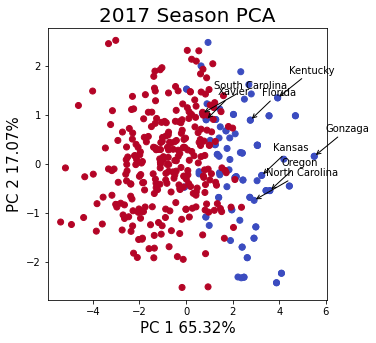

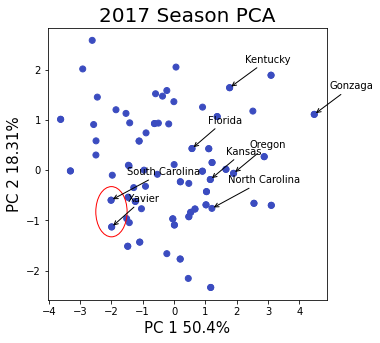

In [162]:
season = 2017
mmt_list = march_madness_teams(season,tourney_result)
mmt_df = pd.DataFrame(columns = ['TeamID','March_mad_team'])
mmt_df['TeamID'] = mmt_list
mmt_df['March_mad_team'] = 0.0
season_enriched_mmt_list = pd.merge(mmt_df, season_enriched_concat[season_enriched_concat.Season==season],left_on=["TeamID"],right_on="TeamID", how="outer")
season_enriched_mmt_list.fillna(1, inplace=True)

names_list = elite_eight(season,tourney_result)
#names_list=cinderellas



plot_final_four1, pca_coefficients1, pca_df1= PCA_matchup(names_list, season_enriched_mmt_list, features, season,True,draw_ellipse=(0,0))
plot_final_four2, pca_coefficients2, pca_df2= PCA_matchup(names_list, season_enriched_mmt_list, features, season,False,draw_ellipse=(-2,-0.827))

In 2018 season we can Loyola-Chicago stays far the rest of the teams.

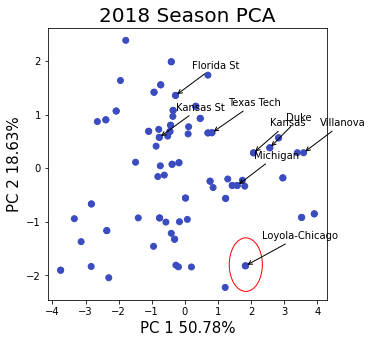

In [167]:
season = 2018
mmt_list = march_madness_teams(season,tourney_result)
mmt_df = pd.DataFrame(columns = ['TeamID','March_mad_team'])
mmt_df['TeamID'] = mmt_list
mmt_df['March_mad_team'] = 0.0
season_enriched_mmt_list = pd.merge(mmt_df, season_enriched_concat[season_enriched_concat.Season==season],left_on=["TeamID"],right_on="TeamID", how="outer")
season_enriched_mmt_list.fillna(1, inplace=True)

names_list = elite_eight(season,tourney_result)
#names_list=cinderellas



#plot_final_four1, pca_coefficients1, pca_df1= PCA_matchup(names_list, season_enriched_mmt_list, features, season,True,draw_ellipse=(0,0))
plot_final_four2, pca_coefficients2, pca_df2= PCA_matchup(names_list, season_enriched_mmt_list, features, season,False,draw_ellipse=(1.84,-1.8))

In the case of 2019, every Elite Eight seem to fall closely. That year, no cinderella got to that round as we will have seen in the previous section.

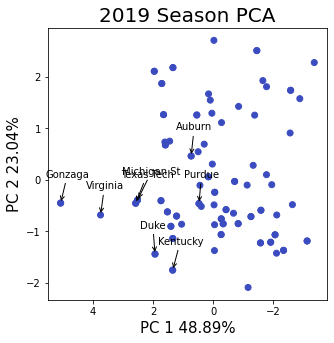

In [168]:
season = 2019
mmt_list = march_madness_teams(season,tourney_result)
mmt_df = pd.DataFrame(columns = ['TeamID','March_mad_team'])
mmt_df['TeamID'] = mmt_list
mmt_df['March_mad_team'] = 0.0
season_enriched_mmt_list = pd.merge(mmt_df, season_enriched_concat[season_enriched_concat.Season==season],left_on=["TeamID"],right_on="TeamID", how="outer")
season_enriched_mmt_list.fillna(1, inplace=True)

names_list = elite_eight(season,tourney_result)
#names_list=cinderellas

#plot_final_four1, pca_coefficients1, pca_df1= PCA_matchup(names_list, season_enriched_mmt_list, features, season,True)

plot_final_four2, pca_coefficients2, pca_df2= PCA_matchup(names_list, season_enriched_mmt_list, features, season,False)
plt.gca().invert_xaxis()

In [44]:
plt.matshow(pca_coefficients,cmap='viridis')
plt.yticks([0,1],['1st Comp','2nd Comp'],fontsize=10)
plt.colorbar()
plt.xticks(range(len(features)),features,rotation=65,ha='left')
#plt.tight_layout()
plt.show()

NameError: name 'pca_coefficients' is not defined

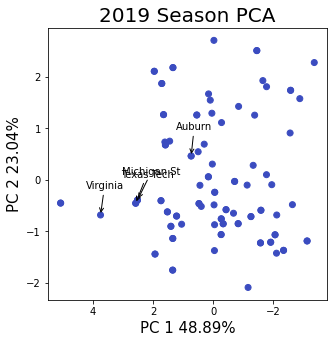

In [169]:
season = 2019
mmt_list = march_madness_teams(season,tourney_result)
mmt_df = pd.DataFrame(columns = ['TeamID','March_mad_team'])
mmt_df['TeamID'] = mmt_list
mmt_df['March_mad_team'] = 0.0
season_enriched_mmt_list = pd.merge(mmt_df, season_enriched_concat[season_enriched_concat.Season==season],left_on=["TeamID"],right_on="TeamID", how="outer")
season_enriched_mmt_list.fillna(1, inplace=True)

names_list = final_four(season,tourney_result)
#names_list=cinderellas

#plot_final_four1, pca_coefficients1, pca_df1= PCA_matchup(names_list, season_enriched_mmt_list, features, season,True)

plot_final_four2, pca_coefficients2, pca_df2= PCA_matchup(names_list, season_enriched_mmt_list, features, season,False)
plt.gca().invert_xaxis()

With the previous representations we have seen that competitive have common charcateristics. If we plot the Final Four teams (2019), even smaller is the distance between those teams. This give us information about the ability of these variables to measure the competitiveness of teams. However, as seen in 2017 and 2018, some dissimilar teams made it to the Elite Eight round, how can we predict this when there is no regular season evidence? Maybe there is, but machine learning methods can't predict something where there is only few of those patterns in the data.

<a id='ml'></a>
<div class="h3">Predicive Model</div>

I trained a XGB model with season data from 2003 to 2019 with every variable from the aggregated dataset:

In [109]:
#tourney_result = pd.read_csv('../input/march-madness-analytics-2020/MDataFiles_Stage2/MNCAATourneyCompactResults.csv')
tourney_result_train = tourney_result[tourney_result.Season>=2003]
season_enriched_concat_train = season_enriched_concat[season_enriched_concat.Season<2020]

# Winning side
Wtrain_df = pd.merge(tourney_result_train, season_enriched_concat_train, left_on=['Season', 'WTeamID'], right_on=['Season', 'TeamID'], how='left')
Wtrain_df = Wtrain_df.drop(['WScore','LScore','WLoc','NumOT','DayNum','TeamName','TeamID','Seed_diff','LSeed'],axis=1)
# We keep LTeamID to merge in the future
Wtrain_df.rename(columns={"WTeamID": "TeamID"},inplace=True)
Wtrain_df.rename(columns={"WSeed": "Seed"},inplace=True)
train_df_2 = Wtrain_df.copy()

for column in Wtrain_df.columns[1:]:
        Wtrain_df.rename(columns={column: column + "_1"},inplace=True)

## Losing side
Ltrain_df = pd.merge(tourney_result_train, season_enriched_concat_train, left_on=['Season', 'LTeamID'], right_on=['Season', 'TeamID'], how='left')
Ltrain_df = Ltrain_df.drop(['WScore','LScore','WLoc','NumOT','DayNum','TeamName','TeamID','WTeamID','Seed_diff','WSeed'],axis=1)
Ltrain_df.rename(columns={"LTeamID": "TeamID"},inplace=True)
Ltrain_df.rename(columns={"LSeed": "Seed"},inplace=True)
train_df_3 = Ltrain_df.copy()

for column in Ltrain_df.columns[1:]:
    if "1" in column[-2:]:
        pass
    else:
        Ltrain_df.rename(columns={column: column + "_2"},inplace=True)
        
upper_train = pd.merge(Wtrain_df,Ltrain_df, left_on=['Season', 'LTeamID_1'], right_on=['Season', 'TeamID_2'], how='left')
#train_df['result'] = 1
upper_train = upper_train.drop(['LTeamID_1'],axis=1)
upper_train['result'] = 1

# Adding distance upper
# comment if no distance used
upper_train = pd.merge(upper_train,loc_df,left_on=['Season','TeamID_1','TeamID_2'],right_on=['Season','WTeamID','LTeamID'],how="left")
upper_train = upper_train.drop(['DayNum','WTeamID','LTeamID','CityID','CityID', 'Dist_diff'],axis=1)
upper_train.rename(columns={"W_dist": "Dist_1"},inplace=True)
upper_train.rename(columns={"L_dist": "Dist_2"},inplace=True)

# Duplicate upper_train and reverse it to add result = 0
for column in train_df_2.columns[1:]:
    train_df_2.rename(columns={column: column + "_2"},inplace=True)

for column in train_df_3.columns[1:]:
    train_df_3.rename(columns={column: column + "_1"},inplace=True)
train_df_2.head()

lower_train = pd.merge(train_df_3,train_df_2, left_on=['Season', 'TeamID_1'], right_on=['Season', 'LTeamID_2'], how='left')
lower_train = lower_train.drop(['LTeamID_2'],axis=1)
lower_train['result'] = 0

# Adding distance
# comment if no distance used
lower_train = pd.merge(lower_train,loc_df,left_on=['Season','TeamID_2','TeamID_1'],right_on=['Season','WTeamID','LTeamID'],how="left")
lower_train = lower_train.drop(['DayNum','WTeamID','LTeamID','CityID','CityID', 'Dist_diff'],axis=1)
lower_train.rename(columns={"W_dist": "Dist_2"},inplace=True)
lower_train.rename(columns={"L_dist": "Dist_1"},inplace=True)

train = pd.concat((upper_train,lower_train)).reset_index(drop=True)
train['season_elo_1'] = train['season_elo_1'].astype(float)
train['season_elo_2'] = train['season_elo_2'].astype(float)
#train['L10wins_2'].describe()
test = train.copy()
test = test[test.Season==2019]

# Following line just for distance
#train = train[train.Season>=2010]

train = train[train.Season!=2019]
#display(train.head(5))



train.pop('Dist_1')
train.pop('Dist_2')
y = train.pop('result')
train = train.drop(['Season','TeamID_1','TeamID_2'],axis=1)
X_initial = train


final_cols = train.columns
X = X_initial[final_cols].copy()

display(X.head())

y_test = test.pop('result')
X_test = test[final_cols].copy()


xgbdata = xgb.DMatrix(data=X,label=y.to_numpy())


,AstR_1,AstR_2,Blk_1,Blk_2,DR_1,DR_2,FGA3_1,FGA3_2,FTAR_1,FTAR_2,...,Stl_1,Stl_2,TOR_1,TOR_2,TSP_1,TSP_2,eFGP_1,eFGP_2,season_elo_1,season_elo_2
0,13.598494,14.483076,3.000000,2.233333,23.172414,24.800000,18.000000,18.500000,0.377214,0.529491,...,7.068966,6.433333,17.074406,15.773560,54.182467,53.981890,0.489800,0.503036,1324.060935,1292.110597
1,16.071897,15.154550,4.214286,2.965517,27.642857,25.724138,20.071429,15.482759,0.387965,0.356274,...,8.464286,6.862069,13.485207,15.293538,55.733373,52.838260,0.517632,0.494732,2039.169204,1444.906840
2,15.835780,16.407177,4.241379,5.068966,23.310345,25.965517,12.586207,20.068966,0.468561,0.396624,...,5.206897,7.379310,14.340035,13.683507,55.735448,53.449587,0.517334,0.498337,1775.777788,1822.852124
3,15.826749,17.170311,4.000000,4.454545,23.275862,23.181818,17.931034,20.484848,0.481836,0.354147,...,7.103448,8.393939,18.785245,13.897726,62.403685,59.690051,0.572835,0.567455,1647.435939,1827.457545
4,16.240148,15.869982,2.793103,3.066667,24.379310,22.033333,17.034483,22.500000,0.348311,0.387496,...,6.551724,7.766667,14.534954,15.649349,55.645587,58.210991,0.524098,0.534189,1853.236979,1818.383163


 I use this approach to see what variables does the model consider as important. To do so I get the Tree SHAP values which outputs:

In [105]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss
import xgboost as xgb
from xgboost import plot_tree
import shap

params = {'objective': 'binary:logistic',
          'eval_metric': 'logloss',
          'eta': 0.03,
          'max_depth': 3
          }

cv_scores = xgb.cv(dtrain=xgbdata,
                    params=params,
                    nfold=5,
                    num_boost_round=100,
                    early_stopping_rounds=60,
                    verbose_eval=False,
                    #as_pandas=True,
                    seed=135
                    )
best_score = cv_scores['test-logloss-mean'].min()
best_round = cv_scores['test-logloss-mean'].idxmin()
print(f'Model Score: {best_score:.2f} log loss after {best_round} iterations.')

#preds = model_final.predict(dval, ntree_limit=cv_scores.best_ntree_limit)
#oof_preds[val_idx] = preds
#score = log_loss(y, oof_preds)


Model Score: 0.52 log loss after 99 iterations.


In [106]:
params = {'objective': 'binary:logistic',
          'eval_metric': 'logloss',
          'eta': 0.03,
          'max_depth': 3
          }

skf = StratifiedKFold(n_splits=10, random_state=2233)
oof_preds = np.zeros((len(train)))
for train_idx, val_idx in skf.split(X, y):
    X_train, X_val = X.loc[train_idx], X.loc[val_idx]
    y_train, y_val = y.to_numpy()[train_idx], y.to_numpy()[val_idx]
    dtrain = xgb.DMatrix(data=X_train, label=y_train)
    dval = xgb.DMatrix(data=X_val, label=y_val)
    watchlist = [(dtrain, 'train'), (dval, 'eval')]
    model_final = xgb.train(params,
                            dtrain,
                            num_boost_round=100,
                            evals=watchlist,
                            early_stopping_rounds=60,
                            verbose_eval=False
                            )
    preds = model_final.predict(dval, ntree_limit=model_final.best_ntree_limit)
    oof_preds[val_idx] = preds
score = log_loss(y, oof_preds)
#print(f'Optimized Model Score: {score:.2f} log loss.')

## Test data (one season tournament)
test_xgb_data = xgb.DMatrix(data=X_test, label=y_test)
preds = model_final.predict(test_xgb_data, ntree_limit=model_final.best_ntree_limit)
#preds_test = np.zeros((len(X_test)))
#preds_test[] = preds
score = log_loss(y_test, preds)
print(f'Optimized Model Score: {score:.2f} log loss.')

Optimized Model Score: 0.53 log loss.


In [107]:
explainer = shap.TreeExplainer(model_final, data=X,
                               model_output='probability')
shap_values_final = explainer.shap_values(X)

100%|===================| 3424/3428 [03:38<00:00]        

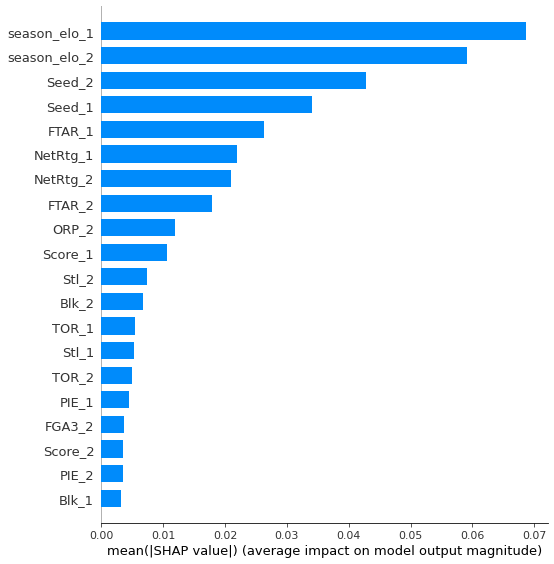

None

In [108]:
display(shap.summary_plot(shap_values_final, X,plot_type="bar"))

The model agrees with the PCA analysis, Elo rating points, NetRG and FTAR are detected as the most important features together with the human seeding. After iterating once again but with the 8 most important features, the model reduces it logloss score. However, I haven't spent time tuning hyperparamenters or doing feature engineering to push the logloss value since it considered this was not the purpuse of this competition.

In [91]:
X_initial = train


final_cols = ['NetRtg_1', 'FTAR_1',
                'season_elo_1', 'Seed_1',
              'NetRtg_2', 'FTAR_2',
                'season_elo_2', 'Seed_2']

#final_cols = train.columns
X = X_initial[final_cols].copy()

params = {'objective': 'binary:logistic',
          'eval_metric': 'logloss',
          'eta': 0.03,
          'max_depth': 3
          }

skf = StratifiedKFold(n_splits=10, random_state=2233)
oof_preds = np.zeros((len(train)))
for train_idx, val_idx in skf.split(X, y):
    X_train, X_val = X.loc[train_idx], X.loc[val_idx]
    y_train, y_val = y.to_numpy()[train_idx], y.to_numpy()[val_idx]
    dtrain = xgb.DMatrix(data=X_train, label=y_train)
    dval = xgb.DMatrix(data=X_val, label=y_val)
    watchlist = [(dtrain, 'train'), (dval, 'eval')]
    model_final = xgb.train(params,
                            dtrain,
                            num_boost_round=100,
                            evals=watchlist,
                            early_stopping_rounds=60,
                            verbose_eval=False
                            )
    preds = model_final.predict(dval, ntree_limit=model_final.best_ntree_limit)
    oof_preds[val_idx] = preds
score = log_loss(y, oof_preds)
#print(f'Optimized Model Score: {score:.2f} log loss.')

## Test data (one season tournament)
test_xgb_data = xgb.DMatrix(data=X_test, label=y_test)
preds = model_final.predict(test_xgb_data, ntree_limit=model_final.best_ntree_limit)
#preds_test = np.zeros((len(X_test)))
#preds_test[] = preds
score = log_loss(y_test, preds)
print(f'Optimized Model Score: {score:.2f} log loss.')

Optimized Model Score: 0.50 log loss.


In [92]:
explainer = shap.TreeExplainer(model_final, data=X,
                               model_output='probability')
shap_values_final = explainer.shap_values(X)

100%|===================| 3419/3428 [03:35<00:00]        

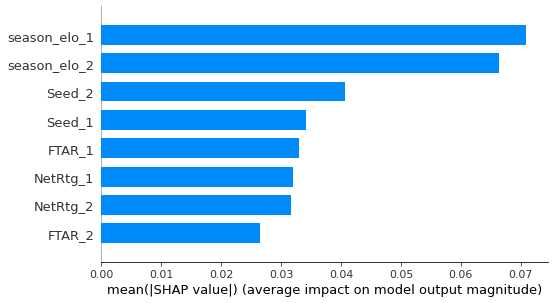

None

In [93]:
display(shap.summary_plot(shap_values_final, X,plot_type="bar"))

<a id='fail'></a>
<div class="h3">Where do predictive models fail?</div>

<div class="h4">Loyola Chicago 2018 case study</div>

Loyola Chicago was seeded 11 in the 2018 tournament, however they managed to get through the South Regional conference bracket reaching the Final Four participation. If you watch this team games one can observe a play that is repeated over and over again. In the offensive end one of the centers does a screen in the top of the 3-pointer line (see below footage). A pick&roll, pick&pop or penetration opportunities arise from there, giving Loyola the opportunity to score an easy layout/dunk under the basket or a 3-point shot. Seems that rivals struggled to deffend that play, which could be a key of the succesful tournament run.

<img src="https://github.com//javiferran/ncaa-analytics-2020/blob/master/loyola_2018.gif?raw=true[](http://)" alt="zeke" height="400" width="720"/>

I analysed the play-by-play dataset to obtain the average number of dunks or layouts per game and 3-pointers made during the regular season. The Loyola results are:

In [48]:
Loyola_below_basket = MEvents_2018[(MEvents_2018.EventTeamID==id_calculator('Loyola-Chicago')) & ((MEvents_2018.EventType=='made3') | ((MEvents_2018.EventType=='made2') & ((MEvents_2018.EventSubType=='lay') | (MEvents_2018.EventSubType=='dunk'))))]
# made 2
Loyola_below_basket_agg = (Loyola_below_basket[Loyola_below_basket.EventType=='made2'].groupby(['Season', 'DayNum'])['EventSubType']
                     .count()
                     .rename('under_basket_per_game')
                     .reset_index())
## Aggreageted regular season
Loyola_below_basket_agg_season = (Loyola_below_basket_agg[Loyola_below_basket_agg.DayNum<136].groupby(['Season'])['under_basket_per_game']
                     .mean()
                     .rename('Dunk/Layout_avg')
                     .reset_index())
# made3
Loyola_made3_agg = (Loyola_below_basket[Loyola_below_basket.EventType=='made3'].groupby(['Season', 'DayNum'])['EventSubType']
                     .count()
                     .rename('made3_per_game')
                     .reset_index())
## Aggreageted regular season
Loyola_made3_agg_season = (Loyola_made3_agg[Loyola_made3_agg.DayNum<136].groupby(['Season'])['made3_per_game']
                     .mean()
                     .rename('Made3_avg')
                     .reset_index())

Loyola_made3_agg_season
Loyola_style = pd.merge(Loyola_below_basket_agg_season,Loyola_made3_agg_season,left_on=["Season"],right_on=["Season"],how="left")
display(Loyola_style)

,Season,Dunk/Layout_avg,Made3_avg
0,2018,13.90625,7.34375


We can observe that Loyola probably played this way during the regular season since a high average of those metrics is obtained.

Now, in order to see how Loyola March Madness rivals have managed a similar offense during regular season I compute the mean of dunks or layouts and 3-pointers __received__ during the 2018 regular season

In [49]:
losers, winners = tournament_rivals('Loyola-Chicago',2018)
#print(losers + winners)
rivals = losers + winners

name_calculator(rivals)
for i, team_identifier in enumerate(rivals):
    #team_identifier = id_calculator(team)
    rival_reveived_basket = MEvents_2018[((MEvents_2018.LTeamID==team_identifier) | (MEvents_2018.WTeamID==team_identifier)) & (MEvents_2018.EventTeamID!=team_identifier) & ((MEvents_2018.EventType=='made3') | ((MEvents_2018.EventType=='made2') & ((MEvents_2018.EventSubType=='lay') | (MEvents_2018.EventSubType=='dunk'))))]
    # made 2
    rival_reveived_below_basket_agg = (rival_reveived_basket[rival_reveived_basket.EventType=='made2'].groupby(['Season', 'DayNum'])['EventSubType']
                         .count()
                         .rename('under_basket_per_game')
                         .reset_index())
    ## Aggreageted regular season
    rival_reveived_below_basket_agg_season = (rival_reveived_below_basket_agg[rival_reveived_below_basket_agg.DayNum<136].groupby(['Season'])['under_basket_per_game']
                         .mean()
                         .rename('Received Dunk/Layout_avg')
                         .reset_index())
    # made 3
    rival_made3_agg = (rival_reveived_basket[rival_reveived_basket.EventType=='made3'].groupby(['Season', 'DayNum'])['EventSubType']
                         .count()
                         .rename('made3_per_game')
                         .reset_index())
    ## Aggreageted regular season
    rival_made3_agg_season = (rival_made3_agg[rival_made3_agg.DayNum<136].groupby(['Season'])['made3_per_game']
                         .mean()
                         .rename('Received_made3_avg')
                         .reset_index())

    rival_style = pd.merge(rival_reveived_below_basket_agg_season,rival_made3_agg_season,left_on=["Season"],right_on=["Season"],how="left")
    rival_style['rival'] = name_calculator([team_identifier])
    if i == 0:
        rival_style_df = rival_style
    else:
        rival_style_df = pd.concat((rival_style_df,rival_style)).reset_index(drop=True)

rival_style_df['Round'] = [64,32,16,8,4]
display(rival_style_df)

,Season,Received Dunk/Layout_avg,Received_made3_avg,rival,Round
0,2018,11.193548,6.900000,Miami FL,64
1,2018,10.818182,6.363636,Tennessee,32
2,2018,11.735294,7.470588,Nevada,16
3,2018,9.848485,7.090909,Kansas St,8
4,2018,8.500000,5.558824,Michigan,4


Loyola obtained 4 wins, even beating Tennesse (3), all of them where teams that during that regular season allowed on average a high number of baskets where Loyola was proven to be very good at. However, when they faced Michigan, a team with good defense performance in under basket and 3-point shots, things didn't turn out well for the Loyola offense system, scoring just eight dunks/lyouts and one 3-point shot.

<div class="h3">South Carolina 2017 case study</div>

South Carolina team was seeded 7. However, its Elo rating had 1801.42 points at the end of the season. In fact, it was placed the 41º best team in Elo rating classification. So based on a predictive model that heavily weights this factor it is very difficult to determine that South Carolina could become a cinderella.

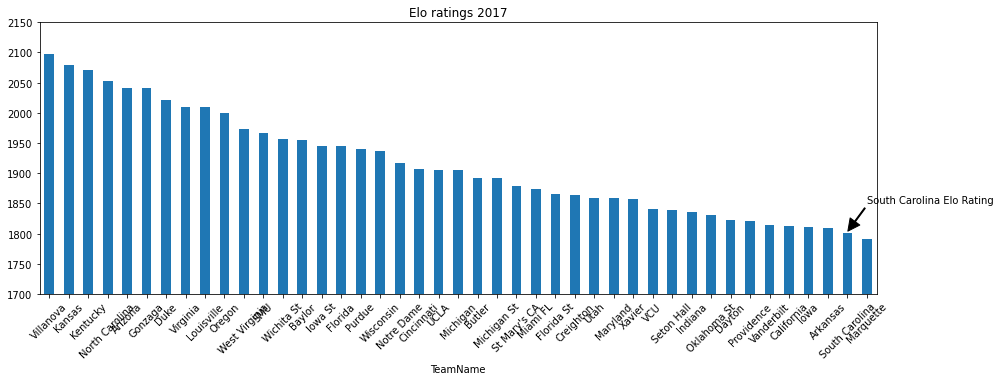

In [50]:
fig = px.bar(season_enriched_concat[season_enriched_concat.Season==2017].sort_values('Score',ascending=False)[0:43], 
             x="TeamID", 
             y="Score",
             title='Score average in season')
season_enriched_concat_name = season_enriched_concat.set_index(['TeamName'])
season_enriched_concat_name[season_enriched_concat_name.Season==2017]['season_elo'] \
    .sort_values(ascending=False)[0:43] \
    .plot(kind='bar',
          figsize=(15, 5),
         title='Elo ratings 2017')
plt.xticks(rotation=45)
plt.ylim(1700,2150)
plt.annotate('South Carolina Elo Rating', xy=(41, 1803), xytext=(42, 1850),
            arrowprops=dict(facecolor='black', shrink=0.025,width=1),
            )
plt.show()

In [51]:
MEvents_2017[MEvents_2017.EventType=='block']
season_enriched_concat[(season_enriched_concat.Season==2017) & (season_enriched_concat.TeamID==id_calculator('South Car'))]

,Season,TeamID,Score,eFGP,NetRtg,PIE,Pos,AstR,Stl,Blk,FTAR,ORP,TOR,TSP,FGA3,DR,season_elo,L10wins,TeamName
5044,2017,1376,71.483871,0.470148,9.587962,0.580692,67.543123,12.982481,7.903226,3.677419,0.402805,0.3406,14.094235,51.770901,19.903226,23.483871,1801.42,4,South Carolina


In [52]:
#id_calculator('South Car') -> 1376
loc_df[(loc_df.Season==2017) & (loc_df.WTeamID==1376) & (loc_df.DayNum == 137)]['W_dist']

1052    160.752787
1053    160.752787
Name: W_dist, dtype: float64

But South Carolina played the first two games in Greenville (South Carolina State), just around 160 miles from University of South Carolina. So, coming from a 71.58 points/game during regular season, they scored 93 and 88 points against Marquette (10) and Duke (2). And, from a regular season average of 7.9 steals/game and 3.67 blocks, they overperformed with 11 steals and 5 blocks agains Duke. Bear in mind that Duke was seeded 2 with only 4.74 steals and 2.77 blocks received per game.

In [53]:
# Gets avg of season under basket and made3
South_Car_below_basket = MEvents_2017[(MEvents_2017.EventTeamID==id_calculator('South Car')) & ((MEvents_2017.EventType=='steal') | (MEvents_2017.EventType=='block'))]
# made 2
South_Car_steal_agg = (South_Car_below_basket[South_Car_below_basket.EventType=='steal'].groupby(['Season', 'DayNum'])['EventType']
                     .count()
                     .rename('steal_per_game')
                     .reset_index())
## Aggreageted regular season
South_Car_steal_agg_season = (South_Car_steal_agg[South_Car_steal_agg.DayNum<136].groupby(['Season'])['steal_per_game']
                     .mean()
                     .rename('avg_steal_per_game')
                     .reset_index())
# made3
South_Car_blocks_agg = (South_Car_below_basket[South_Car_below_basket.EventType=='block'].groupby(['Season', 'DayNum'])['EventType']
                     .count()
                     .rename('blocks_per_game')
                     .reset_index())
## Aggreageted regular season
South_Car_blocks_agg_season = (South_Car_blocks_agg[South_Car_blocks_agg.DayNum<136].groupby(['Season'])['blocks_per_game']
                     .mean()
                     .rename('avg_blocks_per_game')
                     .reset_index())

South_car_style = pd.merge(South_Car_steal_agg_season,South_Car_blocks_agg_season,left_on=["Season"],right_on=["Season"],how="left")
display(South_car_style)

,Season,avg_steal_per_game,avg_blocks_per_game
0,2017,7.903226,3.677419


In [73]:
losers, winners = tournament_rivals('South Car',2017)
#print(losers + winners)
rivals = losers + winners
#print(rivals)
name_calculator(rivals)
for i, team_identifier in enumerate(rivals):
    #team_identifier = id_calculator(team)
    rival_reveived_basket = MEvents_2017[((MEvents_2017.LTeamID==team_identifier) | (MEvents_2017.WTeamID==team_identifier)) & (MEvents_2017.EventTeamID!=team_identifier) & ((MEvents_2017.EventType=='steal') | ((MEvents_2017.EventType=='block')))]
    # made 2
    rival_reveived_below_basket_agg = (rival_reveived_basket[rival_reveived_basket.EventType=='steal'].groupby(['Season', 'DayNum'])['EventType']
                         .count()
                         .rename('steal_per_game')
                         .reset_index())
    ## Aggreageted regular season
    rival_reveived_below_basket_agg_season = (rival_reveived_below_basket_agg[rival_reveived_below_basket_agg.DayNum<136].groupby(['Season'])['steal_per_game']
                         .mean()
                         .rename('Received steals season avg')
                         .reset_index())
    # made 3
    rival_made3_agg = (rival_reveived_basket[rival_reveived_basket.EventType=='block'].groupby(['Season', 'DayNum'])['EventType']
                         .count()
                         .rename('blocks_per_game')
                         .reset_index())
    ## Aggreageted regular season
    rival_made3_agg_season = (rival_made3_agg[rival_made3_agg.DayNum<136].groupby(['Season'])['blocks_per_game']
                         .mean()
                         .rename('Received blocks season avg')
                         .reset_index())

    rival_style = pd.merge(rival_reveived_below_basket_agg_season,rival_made3_agg_season,left_on=["Season"],right_on=["Season"],how="left")
    rival_style['rival'] = name_calculator([team_identifier])
    if i == 0:
        rival_style_df = rival_style
    else:
        rival_style_df = pd.concat((rival_style_df,rival_style)).reset_index(drop=True)

rival_style_df['Round'] = [64,32,16,8,4]

#rival_style_df['Received steals by S. Carolina'] = rival_made3_agg[['blocks_per_game']][-5:].to_numpy()
display(rival_style_df)
#rival_reveived_below_basket_agg

,Season,Received steals season avg,Received blocks season avg,rival,Round
0,2017,6.419355,3.896552,Marquette,64
1,2017,4.742857,2.774194,Duke,32
2,2017,5.322581,3.964286,Baylor,16
3,2017,5.656250,3.464286,Florida,8
4,2017,5.212121,3.222222,Gonzaga,4


Loyola University Chicago 2018 and University of South Carolina 2017 are some examples of team performances that didn't shared the common characteristics of the rest of Elite teams. After a detailed analysis on specific matchups one can come up with a guess based on not only the regular season performance metrics, but also the precise characteristics of rivals. This is a huge challenge for common machine learning algorithms as I have shown in this notebook.

In [ ]:
%matplotlib inline
from xgboost import plot_tree

##set up the parameters
rcParams['figure.figsize'] = 50,100
plot_tree(model_final,num_trees=2);

In [ ]:
rcParams['figure.figsize'] = 5,5
plt.hist(oof_preds, bins = 10) 
plt.title("histogram") 
plt.show()

In [ ]:
# load JS visualization code to notebook
shap.initjs()
display(shap.force_plot(explainer.expected_value, shap_values_final[0,:], X.iloc[0,:]))

In [ ]:
shap.summary_plot(shap_values_final, X)